In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import multiprocessing
import scipy.special
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

In [3]:
from conversion import rotation_matrix_fromq,rotation_matrix_from_params,rotation_matrix_to_q,angles_from_q
from utils import to_radian,res_to_rad,ax_to_w,rep_to_angle
from visualize import plot_cost_func,plot_cost_func_t,plot_volume,plot_slices
from cost_functions import cf_ssd

In [4]:
from rotation_3d import trilinear_interp,volrotate_trilinear
from rotation_3d import tricubic_derivatives,tricubic_interp,volrotate_tricubic
from rotation_3d import BSpline_coefficients, Bspline_interp_1d, Bspline_interp, BSpline_derivatives, volrotate_bspline
from rotation_3d import rotate_coords_3d, rotation_matrix_zyx, rot_cost_func_3d
from Gauss_Newton import Gauss_Newton, Gauss_Newton1, print_results,sphere_mask, get_mask_weights, fourier_filter,get_gradient_P

In [5]:
oct13_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_10.p','rb'))
oct13_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_8.p','rb'))
oct13_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_6_4.p','rb'))

In [6]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Dropbox/THESIS/Oct_13_navs/'
ranges = ['0_5_to_2_5','3_0_to_5_0']
files = os.listdir(path)
axes_dict = {}
for f in files[1:]:
    rot_ax = f.split('_')[2]
    trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict
print axes_dict.keys()
keys = ['xy', 'xz', 'yz', 'y', 'x', 'z']

{'xz': 'xy', 'y': 'z', 'yz': 'xy', 'xy': 'xy', 'x': 'z', 'z': 'z'}
['xz', 'y', 'yz', 'xy', 'x', 'z']


In [7]:
import multiprocessing
def run_rot_3d_cost(rot_ax):
    wx, wy, wz = ax_to_w(rot_ax)
    print rot_ax,
    cost_dict = {}
    cost_dict['trilinear'] = {}
    cost_dict['tricubic'] = {}
    cost_dict['bspline'] = {}
    for rang in ranges:
        print rang,
        for i in xrange(6):
            ref = rep_to_angle(i*6, rang)
            vol_ref = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][ref],rad)
            vol_ref_masked = mask_weights * vol_ref
            for rep in xrange(1,6):
                rot_angle = rep_to_angle(i*6 + rep,rang)
                thetas = np.arange(rot_angle[0]-0.3, rot_angle[0]+0.3,0.1)
                print rot_angle,
                vol_m = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][rot_angle],rad)
                vol_m_dervs_bspline = BSpline_coefficients(vol_m)
                vol_m_dervs_cubic = tricubic_derivatives(vol_m)
                cost_dict['trilinear'][rot_angle] = rot_cost_func_3d(vol_ref_masked, vol_m, thetas, 
                                                  wx, wy, wz, xx, yy, zz, mask_weights, interpolation = 'trilinear')
                cost_dict['tricubic'][rot_angle] = rot_cost_func_3d(vol_ref_masked, vol_m_dervs_cubic, thetas, 
                                                 wx, wy, wz, xx, yy, zz, mask_weights, interpolation = 'tricubic')
                cost_dict['bspline'][rot_angle] = rot_cost_func_3d(vol_ref_masked, vol_m_dervs_bspline, thetas, 
                                                wx, wy, wz, xx, yy, zz,  mask_weights, interpolation = 'bspline')
    return cost_dict

In [8]:
dict_ = oct13_dict_10
res = '10'
rad = res_to_rad(res)
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
mask_weights = get_mask_weights(xx.shape, rad)

In [22]:
cost_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/oct13_rot_3d_cost_6_4.p','rb'))
cost_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/oct13_rot_3d_cost_8.p','rb'))
cost_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/oct13_rot_3d_cost_10.p','rb'))

In [12]:
trans_cost_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_trans_3d_cost_6_4.p','rb'))
trans_cost_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_trans_3d_cost_8.p','rb'))
trans_cost_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_trans_3d_cost_10.p','rb'))

In [9]:
def run_trans_3d_cost(rot_ax):
    trans_ls = np.arange(-2.1,2.1,0.01)
    wx, wy, wz = ax_to_w(axes_dict[rot_ax])
    print rot_ax,
    cost_dict = {}
    cost_dict['trilinear'] = {}
    cost_dict['tricubic'] = {}
    cost_dict['bspline'] = {}
    for rang in ranges:
        print rang,
        for i in xrange(1,6):
            ref = rep_to_angle(i, rang)
            vol_ref = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][ref],rad)
            vol_ref_masked = mask_weights * vol_ref
            for rep in xrange(1,6):
                rot_angle = rep_to_angle(i + rep*6,rang)
                true_trans = rot_angle[1]/float_res
                print rot_angle,
                vol_m = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][rot_angle],rad)
                vol_m_dervs_bspline = BSpline_coefficients(vol_m)
                vol_m_dervs_cubic = tricubic_derivatives(vol_m)
                cost_dict['trilinear'][rot_angle] = trans_cost_func_3d(vol_ref_masked, vol_m, trans_ls, 
                                                  wx, wy, wz, xx, yy, zz, mask_weights, interpolation = 'trilinear')
                cost_dict['tricubic'][rot_angle] = trans_cost_func_3d(vol_ref_masked, vol_m_dervs_cubic, trans_ls, 
                                                 wx, wy, wz, xx, yy, zz, mask_weights, interpolation = 'tricubic')
                cost_dict['bspline'][rot_angle] = trans_cost_func_3d(vol_ref_masked, vol_m_dervs_bspline, trans_ls, 
                                                wx, wy, wz, xx, yy, zz,  mask_weights, interpolation = 'bspline')
    print
    return cost_dict

In [11]:
def error_plot(cost_dict, col, xlim = [0,5]):
    colors = ['red','blue','green','orange','brown','purple']
    ranges = ['0_5_to_2_5','3_0_to_5_0']
    for i in xrange(6):
        plt.scatter(cost_dict[i*60:(i+1)*60],np.zeros(60)+col, lw=0, s = 80, c = colors[i], alpha = 0.1,marker='o')
        plt.xlim(xlim)
        plt.ylim([0,10])
        
def error_plot_trans(cost_dict, col, xlim = [0,5]):
    colors = ['red','blue','green','orange','brown','purple']
    ranges = ['0_5_to_2_5','3_0_to_5_0']
    for i in xrange(6):
        plt.scatter(cost_dict[i*50:(i+1)*50],np.zeros(50)+col, lw=0, s = 80, c = colors[i], alpha = 0.1,marker='o')
        plt.xlim(xlim)
        plt.ylim([0,10])

In [12]:
# plotting quantiles
def error_plot_all(figsize, rotation = True, error_plot = error_plot):
    b_spline_quantiles = []
    cubic_quantiles = []
    linear_quantiles = []
    colors = ['red','blue','green','orange','brown','purple']
    quantile_colors = ['blue','black','red','black','blue']
    y = np.arange(1,10)
    labels = ['10mm\nCubic\nB-spline','10mm\nTricubic','10mm\nTrilinear',
              '8mm\nCubic\nB-spline','8mm\nTricubic','8mm\nTrilinear',
              '6.4mm\nCubic\nB-spline','6.4mm\nTricubic','6.4mm\nTrilinear']
    plt.figure(figsize = figsize)
    plt.yticks(y, labels, rotation='horizontal',fontsize=18)
    plt.xticks(fontsize=18)
    for idx, rot_ax in enumerate(keys):
        if rot_ax == 'x':
            label = 'x (LR/partition) rotation, z translation'
        elif rot_ax == 'y':
            label = 'y (AP/phase) rotation, z translation'
        elif rot_ax == 'z':
            label = 'z (HF/readout) rotation, z translation'
        else: 
            label = rot_ax + " rotation, xy translation"
        plt.scatter(-3, -3, lw=0,s = 150, c = colors[idx],alpha = 0.3,marker='o' , label=label)
    plt.plot([-4,-5],[-4,-5],lw=1,c='red',label='median')
    plt.plot([-4,-5],[-4,-5],lw=1,c='black',label='25%, 75% quantile')
    plt.plot([-4,-5],[-4,-5],lw=1,c='blue',label='5%, 95% quantile')

    idx = 1
    error_plot(bspline_errors_10,idx)
    b_spline_quantiles.append(np.percentile(np.array(bspline_errors_10),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(bspline_errors_10),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1 
    error_plot(tricubic_errors_10,idx)
    cubic_quantiles.append(np.percentile(np.array(tricubic_errors_10),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(tricubic_errors_10),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)

    idx += 1
    error_plot(trilinear_errors_10,idx)
    linear_quantiles.append(np.percentile(np.array(trilinear_errors_10),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(trilinear_errors_10),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(bspline_errors_8,idx)
    b_spline_quantiles.append(np.percentile(np.array(bspline_errors_8),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(bspline_errors_8),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(tricubic_errors_8,idx)
    cubic_quantiles.append(np.percentile(np.array(tricubic_errors_8),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(tricubic_errors_8),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)

    idx += 1
    error_plot(trilinear_errors_8,idx)
    linear_quantiles.append(np.percentile(np.array(trilinear_errors_8),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(trilinear_errors_8),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)

    idx += 1
    error_plot(bspline_errors_6_4,idx)
    b_spline_quantiles.append(np.percentile(np.array(bspline_errors_6_4),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(bspline_errors_6_4),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(tricubic_errors_6_4,idx)
    cubic_quantiles.append(np.percentile(np.array(tricubic_errors_6_4),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(tricubic_errors_6_4),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(trilinear_errors_6_4,idx)
    linear_quantiles.append(np.percentile(np.array(trilinear_errors_6_4),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(trilinear_errors_6_4),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    plt.vlines(0,0,7,color = 'r',lw=1,linestyle='--')
    if rotation:
        plt.xlim([0,0.7])
        #plt.title("Rotation",fontsize = 20)
        plt.xlabel('Rotation Error (degrees)',fontsize=20)
    else:
        plt.xlim([0,1])
        #plt.title("Translation",fontsize = 20)
        plt.xlabel('Translation Error (mm)',fontsize=20)
    plt.ylim([0.7,9.3])
    plt.legend(loc='center left', bbox_to_anchor=(-0.12, 1.13), ncol=2, scatterpoints=1,fontsize = 20)
    plt.grid('off')
    plt.show()
    return b_spline_quantiles, cubic_quantiles, linear_quantiles

In [10]:
#### Translations
trilinear_errors_10 = []
tricubic_errors_10 = []
bspline_errors_10 = []

trilinear_errors_8 = []
tricubic_errors_8 = []
bspline_errors_8 = []

trilinear_errors_6_4 = []
tricubic_errors_6_4 = []
bspline_errors_6_4 = []
trans_ls = np.arange(-1,1,0.01)
for idx, ax in enumerate(keys):
    for rang in ranges:
        for i in xrange(1,6):
            for rep in xrange(1,6):
                rot_angle = rep_to_angle(i + rep*6,rang)
                true_trans = rot_angle[1]
                trilinear_errors_10.append(abs(rot_angle[1]-abs(trans_ls[np.argmin(trans_cost_10[idx]['trilinear'][rot_angle])])*10.))
                tricubic_errors_10.append(abs(rot_angle[1]-abs(trans_ls[np.argmin(trans_cost_10[idx]['tricubic'][rot_angle])])*10.))
                bspline_errors_10.append(abs(rot_angle[1]-abs(trans_ls[np.argmin(trans_cost_10[idx]['bspline'][rot_angle])])*10.))

                true_trans = rot_angle[1]
                trilinear_errors_8.append(abs(rot_angle[1]-abs(trans_ls[np.argmin(trans_cost_8[idx]['trilinear'][rot_angle])])*8.))
                tricubic_errors_8.append(abs(rot_angle[1]-abs(trans_ls[np.argmin(trans_cost_8[idx]['tricubic'][rot_angle])])*8.))
                bspline_errors_8.append(abs(rot_angle[1]-abs(trans_ls[np.argmin(trans_cost_8[idx]['bspline'][rot_angle])])*8.))

                true_trans = rot_angle[1]
                trilinear_errors_6_4.append(abs(true_trans-abs(trans_ls[np.argmin(trans_cost_6_4[idx]['trilinear'][rot_angle])])*6.4))
                tricubic_errors_6_4.append(abs(true_trans-abs(trans_ls[np.argmin(trans_cost_6_4[idx]['tricubic'][rot_angle])])*6.4))
                bspline_errors_6_4.append(abs(true_trans-abs(trans_ls[np.argmin(trans_cost_6_4[idx]['bspline'][rot_angle])])*6.4))

In [14]:
pickle.dump([trilinear_errors_10,tricubic_errors_10,bspline_errors_10], open('trans_10.p','wb'))
pickle.dump([trilinear_errors_8,tricubic_errors_8,bspline_errors_8], open('trans_8.p','wb'))
pickle.dump([trilinear_errors_6_4,tricubic_errors_6_4,bspline_errors_6_4], open('trans_6_4.p','wb'))

In [31]:
keys

['xy', 'xz', 'yz', 'y', 'x', 'z']

In [29]:
print keys 

rang = '0_5_to_2_5'
ax = 'xy'
idx = 0

rot_angle = (0.5, 2)
true_trans = rot_angle[1]

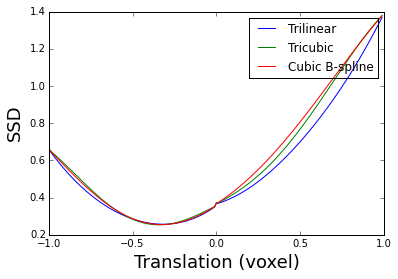

In [30]:
print keys 

rang = '0_5_to_2_5'
ax = 'xy'
idx = 0

rot_angle = (0.5, 2)
true_trans = rot_angle[1]

trans_ls = np.arange(-1,1,0.01)
plt.plot(trans_ls, trans_cost_6_4[idx]['trilinear'][rot_angle], label = 'Trilinear')
plt.plot(trans_ls, trans_cost_6_4[idx]['tricubic'][rot_angle], label = 'Tricubic')
plt.plot(trans_ls, trans_cost_6_4[idx]['bspline'][rot_angle], label = 'Cubic B-spline')
plt.xlabel('Translation (voxel)', fontsize = 18)
plt.ylabel('SSD', fontsize = 18)
plt.legend()
plt.show()

In [ ]:
plt.plot(trans_ls, trans_cost_6_4[idx]['trilinear'][rot_angle])
plt.xlabel('Translation (voxel)', fontsize = 18)
plt.ylabel('SSD', fontsize = 18)
plt.show()

In [16]:
trans_ls = np.arange(-1,1,0.01)
for idx, ax in enumerate(keys):
    for rang in ranges:
        for i in xrange(1,6):
            for rep in xrange(1,6):
                rot_angle = rep_to_angle(i + rep*6,rang)
                true_trans = rot_angle[1]
                if(abs(true_trans-abs(trans_ls[np.argmin(trans_cost_6_4[idx]['trilinear'][rot_angle])])*6.4)) > 0.5:
                    print ax, rang, rot_angle, trans_ls[np.argmin(trans_cost_6_4[idx]['trilinear'][rot_angle])]

y 0_5_to_2_5 (0.5, 1) -0.01
y 0_5_to_2_5 (1.0, 1) -0.01
y 0_5_to_2_5 (1.5, 1) -0.01
y 0_5_to_2_5 (2.0, 1) -0.01
y 0_5_to_2_5 (2.5, 1) -0.01
y 3_0_to_5_0 (3.0, 1) -0.01
y 3_0_to_5_0 (3.5, 1) -0.01
y 3_0_to_5_0 (4.0, 1) -0.01
y 3_0_to_5_0 (4.5, 1) -0.01
y 3_0_to_5_0 (5.0, 1) -0.01
x 0_5_to_2_5 (0.5, 1) -0.01
x 0_5_to_2_5 (1.0, 1) -0.01
x 0_5_to_2_5 (1.5, 1) -0.01
x 0_5_to_2_5 (2.0, 1) -0.01
x 0_5_to_2_5 (2.5, 1) -0.01
x 3_0_to_5_0 (3.0, 1) -0.01
x 3_0_to_5_0 (3.5, 1) -0.01
x 3_0_to_5_0 (4.0, 1) -0.01
x 3_0_to_5_0 (4.5, 1) -0.01
x 3_0_to_5_0 (5.0, 1) -0.01
z 0_5_to_2_5 (0.5, 1) -0.01
z 0_5_to_2_5 (1.0, 1) -0.01
z 0_5_to_2_5 (1.5, 1) -0.01
z 0_5_to_2_5 (2.0, 1) -0.01
z 0_5_to_2_5 (2.5, 1) -0.01
z 3_0_to_5_0 (3.0, 1) -0.01
z 3_0_to_5_0 (3.5, 1) -0.01
z 3_0_to_5_0 (4.0, 1) -0.01
z 3_0_to_5_0 (4.5, 1) -0.01
z 3_0_to_5_0 (5.0, 1) -0.01


//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


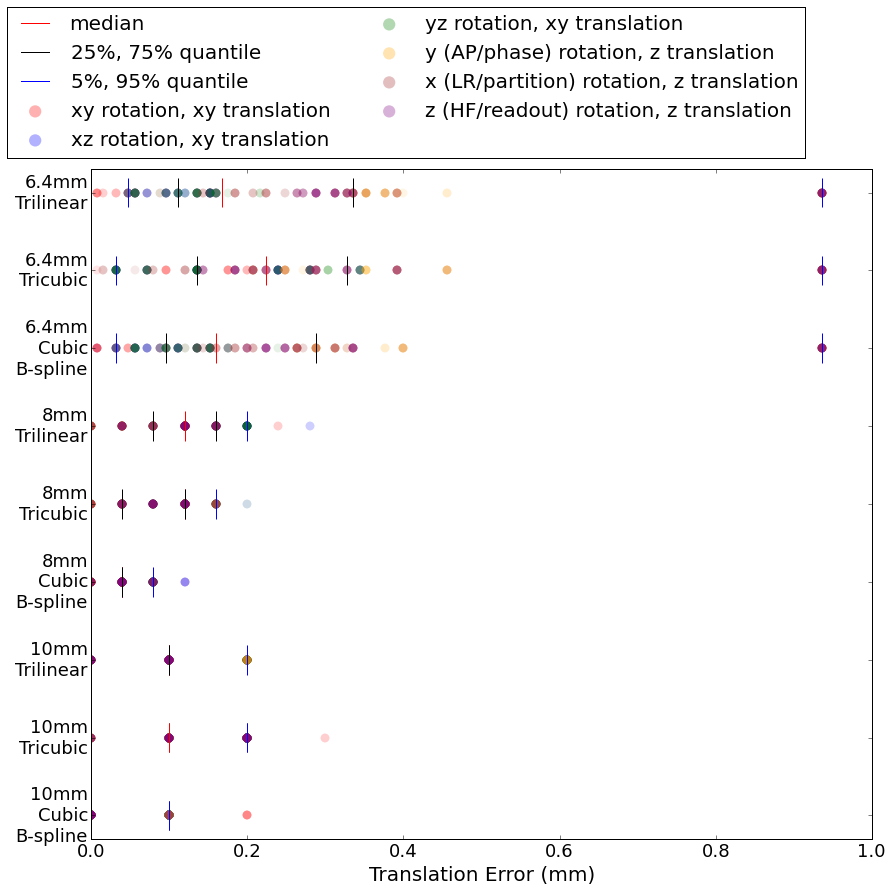

In [16]:
b_spline_quantiles, cubic_quantiles, linear_quantiles = error_plot_all([14,12], False, error_plot = error_plot_trans)

In [17]:
trilinear_errors_10 = []
tricubic_errors_10 = []
bspline_errors_10 = []

trilinear_errors_8 = []
tricubic_errors_8 = []
bspline_errors_8 = []

trilinear_errors_6_4 = []
tricubic_errors_6_4 = []
bspline_errors_6_4 = []

keys = ['xy', 'xz', 'yz', 'y', 'x', 'z']
for idx, ax in enumerate(keys):
    for rang in ranges:
        for i in xrange(6):
            for rep in xrange(1,6):
                rot_angle = rep_to_angle(i*6 + rep,rang)
                thetas = np.arange(rot_angle[0]-0.8, rot_angle[0]+0.8,0.01)

                trilinear_errors_10.append(abs(rot_angle[0]-thetas[np.argmin(cost_10[idx]['trilinear'][rot_angle])]))
                tricubic_errors_10.append(abs(rot_angle[0]-thetas[np.argmin(cost_10[idx]['tricubic'][rot_angle])]))
                bspline_errors_10.append(abs(rot_angle[0]-thetas[np.argmin(cost_10[idx]['bspline'][rot_angle])]))

                trilinear_errors_8.append(abs(rot_angle[0]-thetas[np.argmin(cost_8[idx]['trilinear'][rot_angle])]))
                tricubic_errors_8.append(abs(rot_angle[0]-thetas[np.argmin(cost_8[idx]['tricubic'][rot_angle])]))
                bspline_errors_8.append(abs(rot_angle[0]-thetas[np.argmin(cost_8[idx]['bspline'][rot_angle])]))

                trilinear_errors_6_4.append(abs(rot_angle[0]-thetas[np.argmin(cost_6_4[idx]['trilinear'][rot_angle])]))
                tricubic_errors_6_4.append(abs(rot_angle[0]-thetas[np.argmin(cost_6_4[idx]['tricubic'][rot_angle])]))
                bspline_errors_6_4.append(abs(rot_angle[0]-thetas[np.argmin(cost_6_4[idx]['bspline'][rot_angle])]))

In [18]:
pickle.dump([trilinear_errors_10,tricubic_errors_10,bspline_errors_10], open('rot_10.p','wb'))
pickle.dump([trilinear_errors_8,tricubic_errors_8,bspline_errors_8], open('rot_8.p','wb'))
pickle.dump([trilinear_errors_6_4,tricubic_errors_6_4,bspline_errors_6_4], open('rot_6_4.p','wb'))

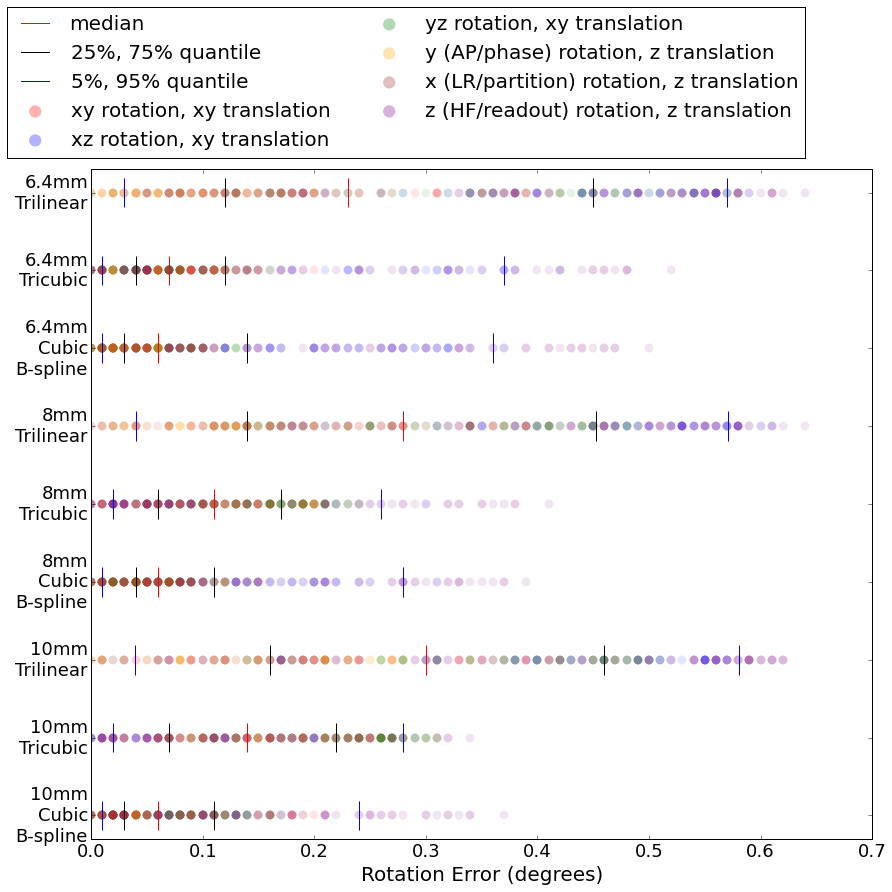

In [19]:
b_spline_quantiles, cubic_quantiles, linear_quantiles = error_plot_all([14,12], True)

In [105]:
def plot_volume_for_report(volume, title, colorbar = False):
    mid_slice = int(volume.shape[0]/2)
    fig, ax = plt.subplots(1,3)
    fig.set_figheight(4.5)
    fig.set_figwidth(13.5)
    if colorbar:
        for i in xrange(3):
            axx = ax[i].imshow(volume.max(axis=i), interpolation = 'None',cmap='gray')
            plt.axes(ax[i])
            fig.colorbar(axx)
    else:
        ax[2].imshow(volume[:,:,mid_slice].T, interpolation = 'None',cmap='gray')
        ax[1].imshow(np.fliplr(np.flipud(volume[:,mid_slice,:].T)), interpolation = 'None',cmap='gray')
        ax[0].imshow(np.fliplr(np.flipud(volume[mid_slice,:,:].T)), interpolation = 'None',cmap='gray')
    [ax[i].get_xaxis().set_ticks([]) for i in xrange(3)]
    [ax[i].get_yaxis().set_ticks([]) for i in xrange(3)]
    plt.tight_layout(pad=0, w_pad=0.3, h_pad=0.0)
    plt.suptitle(title, fontsize=20)
    [ax[i].grid('off') for i in xrange(3)]
    plt.show()
    plt.close(fig)

In [23]:
res = '8'
rad = res_to_rad(res)
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
mask_weights = get_mask_weights(xx.shape, rad)

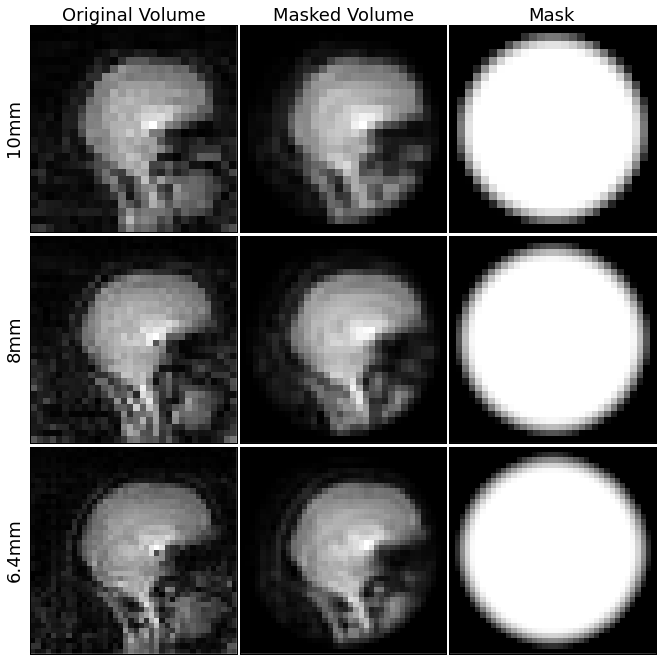

In [17]:
# Plot Sample Volume slice
rot_ax = 'x'
vol_10 = oct13_dict_10[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
vol_8 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
vol_6_4 = oct13_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]

mask_weights_10 = get_mask_weights(vol_10.shape, 13)
mask_weights_8 = get_mask_weights(vol_8.shape, 16)
mask_weights_6_4 = get_mask_weights(vol_6_4.shape, 20)

vol_10_masked = mask_weights_10*fourier_filter(vol_10,13)
vol_8_masked = mask_weights_8*fourier_filter(vol_8,16)
vol_6_4_masked = mask_weights_6_4*fourier_filter(vol_6_4,20)

fig, ax = plt.subplots(3,3)
fig.set_figwidth(9)
fig.set_figheight(9)
ax[0][0].imshow(np.fliplr(np.flipud(vol_10[13,:,:].T)), interpolation = 'None', cmap='gray')
ax[0][0].set_ylabel('10mm',fontsize=18)
ax[0][0].set_title('Original Volume',fontsize=18)
ax[1][0].imshow(np.fliplr(np.flipud(vol_8[16,:,:].T)), interpolation = 'None', cmap='gray')
ax[1][0].set_ylabel('8mm',fontsize=18)
ax[2][0].imshow(np.fliplr(np.flipud(vol_6_4[20,:,:].T)), interpolation = 'None', cmap='gray')
ax[2][0].set_ylabel('6.4mm',fontsize=18)
ax[0][1].imshow(np.fliplr(np.flipud(vol_10_masked[13,:,:].T)), interpolation = 'None', cmap='gray')
ax[0][1].set_title('Masked Volume',fontsize=18)
ax[1][1].imshow(np.fliplr(np.flipud(vol_8_masked[16,:,:].T)), interpolation = 'None', cmap='gray')
ax[2][1].imshow(np.fliplr(np.flipud(vol_6_4_masked[20,:,:].T)), interpolation = 'None', cmap='gray')

ax[0][2].set_title('Mask',fontsize=18)
ax[0][2].imshow(np.fliplr(np.flipud(mask_weights_10[13,:,:].T)), interpolation = 'None', cmap='gray')
ax[1][2].imshow(np.fliplr(np.flipud(mask_weights_8[16,:,:].T)), interpolation = 'None', cmap='gray')
ax[2][2].imshow(np.fliplr(np.flipud(mask_weights_6_4[20,:,:].T)), interpolation = 'None', cmap='gray')
axs = ax.ravel()
[axs[i].get_xaxis().set_ticks([]) for i in xrange(9)]
[axs[i].get_yaxis().set_ticks([]) for i in xrange(9)]
plt.tight_layout(pad=0, w_pad=0.3, h_pad=0.3)
plt.show()

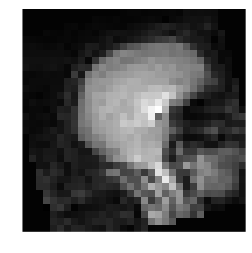

In [131]:
from scipy import ndimage
im1_rot = ndimage.rotate(im1, 15, reshape=False)
plt.imshow(im1_rot, interpolation = 'None', cmap='gray')
plt.axis('off')
plt.show()

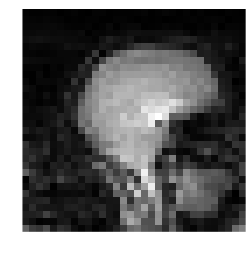

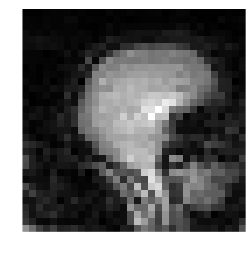

In [132]:
rot_ax = 'x'
vol_8 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
im1 = np.fliplr(np.flipud(vol_8[16,:,:].T))
plt.imshow(im1, interpolation = 'None', cmap='gray')
plt.axis('off')
plt.show()
vol2_8 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
im2 = np.fliplr(np.flipud(vol2_8[16,:,:].T))
plt.imshow(im2, interpolation = 'None', cmap='gray')
plt.axis('off')
plt.show()

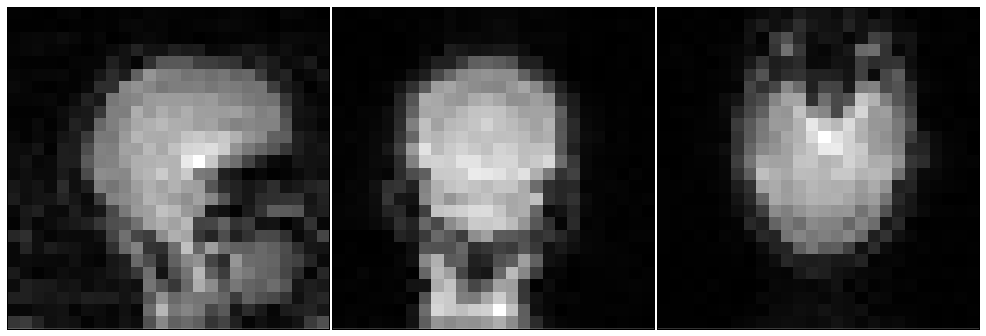

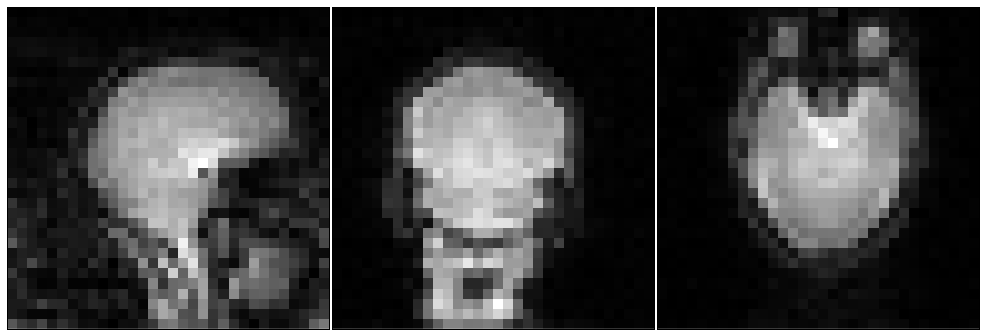

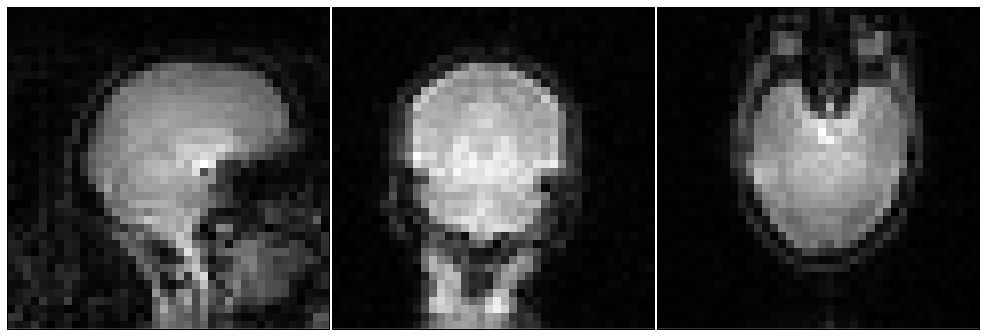

In [107]:
plot_volume_for_report(vol_10, "")
plot_volume_for_report(vol_8, "")
plot_volume_for_report(vol_6_4, "")

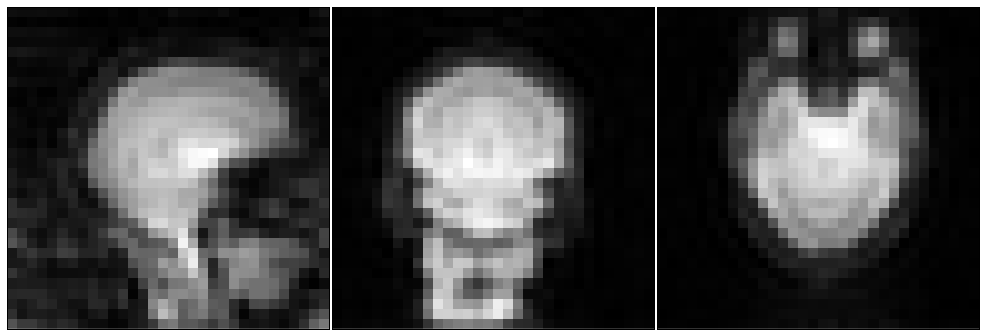

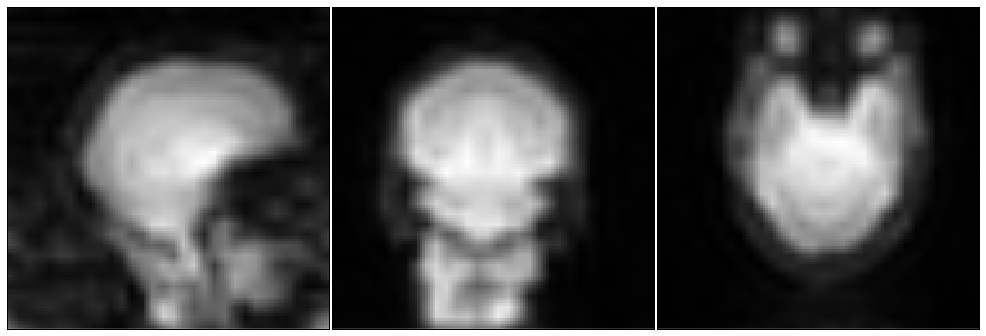

In [283]:
upsampled_vol1_trilinear = trilinear_interp(testVol1, xx1, yy1, zz1)
plot_volume_for_report(testVol1, "")
plot_volume_for_report(upsampled_vol1_trilinear, "")

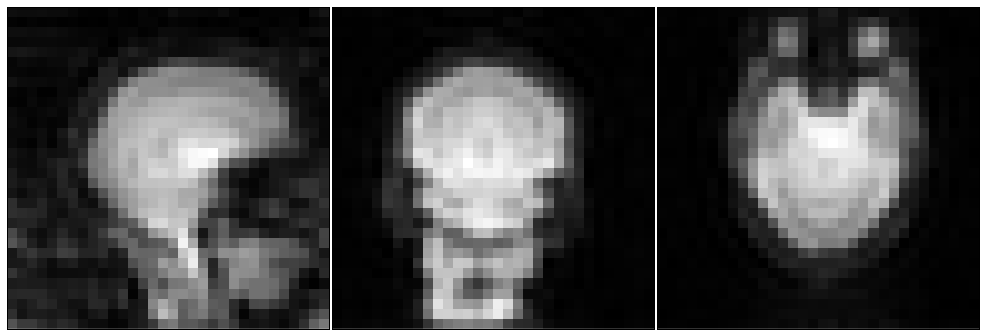

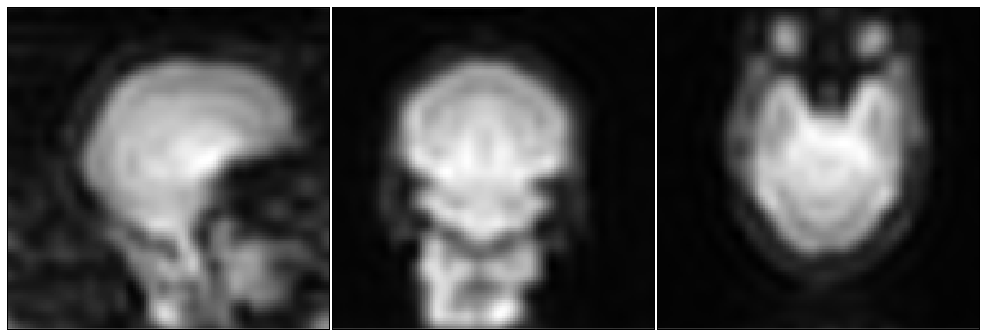

In [200]:
volume_shape = testVol1.shape
vol1_dervs_cubic = tricubic_derivatives(testVol1)
upsampled_vol1_tricubic = np.empty(xx1.shape)
for i in xrange(xx1.shape[0]):
    upsampled_vol1_tricubic[i,:,:] = tricubic_interp(volume_shape,vol1_dervs_cubic,xx1[i,:,:],yy1[i,:,:],zz1[i,:,:])
plot_volume_for_report(testVol1, "")
plot_volume_for_report(upsampled_vol1_tricubic, "")

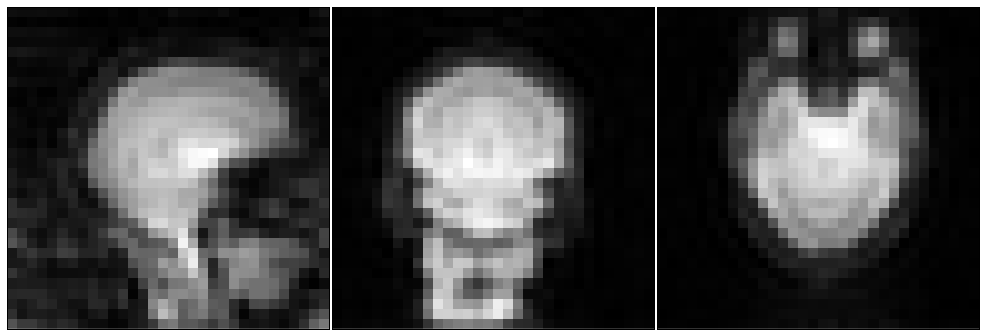

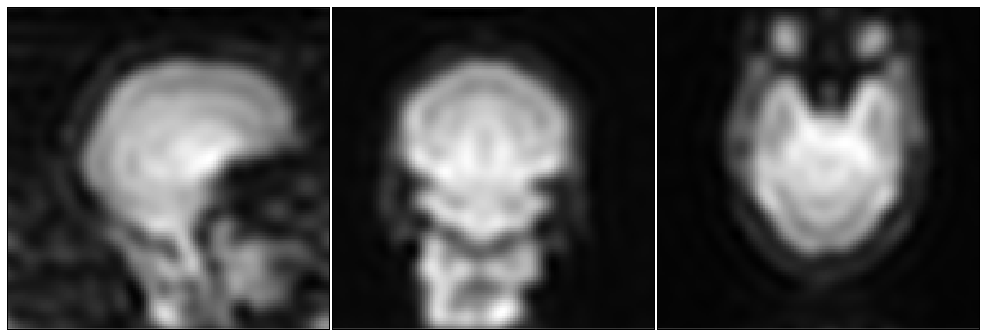

In [201]:
volume_shape = testVol1.shape
vol1_dervs_bspline = BSpline_coefficients(testVol1)
upsampled_vol1_bspline = np.empty(xx1.shape)
for i in xrange(xx1.shape[0]):
    upsampled_vol1_bspline[i,:,:] = Bspline_interp(volume_shape,vol1_dervs_bspline,xx1[i,:,:],yy1[i,:,:],zz1[i,:,:])
plot_volume_for_report(testVol1, "")
plot_volume_for_report(upsampled_vol1_bspline, "")

In [ ]:
%%time
## NON-NORMALIZED VOLUMES
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'xy'
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
mask_weights = get_mask_weights(xx.shape, rad)
# Get two volumes to register
testVol1 = fourier_filter(oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)],rad)
testVol2 = fourier_filter(oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)],rad)
s0,s1,s2 = testVol1.shape

testVol1_masked = sphere_mask(testVol1,rad)

vol2_dervs_bspline = BSpline_coefficients(testVol2)
vol2_dervs_cubic = tricubic_derivatives(testVol2)

In [203]:
from rotation_3d import rot_cost_func_3d
thetas = np.arange(4.5, 5.5, 0.01)
print len(thetas)
wx, wy, wz = ax_to_w(rot_ax)

100


In [204]:
%%time
cost_trilinear = rot_cost_func_3d(testVol1_masked, testVol2, thetas, wx, wy, wz, 
                                  xx, yy, zz, mask_weights,interpolation = 'trilinear')

CPU times: user 622 ms, sys: 103 ms, total: 725 ms
Wall time: 795 ms


In [205]:
%%time
cost_tricubic = rot_cost_func_3d(testVol1_masked, vol2_dervs_cubic, thetas, wx, wy, wz, 
                                 xx, yy, zz, mask_weights, interpolation = 'tricubic')

CPU times: user 7.36 s, sys: 149 ms, total: 7.51 s
Wall time: 8.07 s


In [206]:
%%time
cost_bspline = rot_cost_func_3d(testVol1_masked, vol2_dervs_bspline, thetas, wx, wy, wz, 
                                xx, yy, zz,mask_weights, interpolation = 'bspline')

CPU times: user 7.47 s, sys: 118 ms, total: 7.59 s
Wall time: 7.92 s


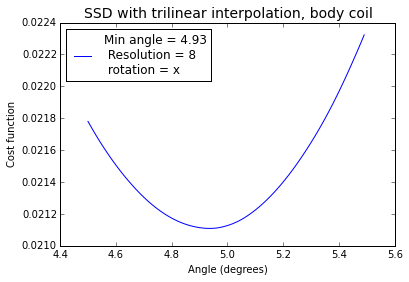

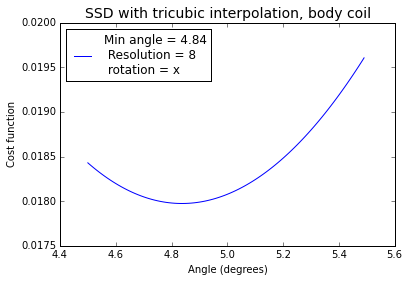

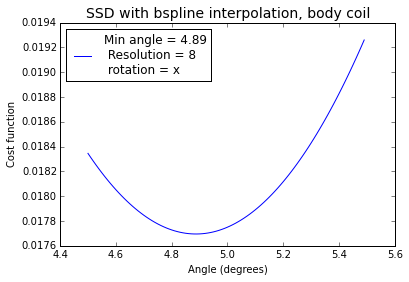

In [207]:
plot_cost_func(thetas,cost_trilinear,res,'trilinear',rot_ax, lw = 1)
plt.show()
plot_cost_func(thetas,cost_tricubic,res,'tricubic',rot_ax, lw = 1)
plt.show()
plot_cost_func(thetas,cost_bspline,res,'bspline',rot_ax, lw = 1)
plt.show()

In [9]:
from Gauss_Newton import rotate_coords_transformation_m

def trans_cost_func_3d(reference, moving, trans_ls, wx, wy, wz, xx, yy, zz, mask_weights, interpolation = 'trilinear'):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    xx,yy,zz: loaded meshgrid
    wx, wy, wz is the unit vector describing the axis of translation
    '''
    rad = reference.shape[0]/2
    cost_func = np.zeros([len(trans_ls)])
    ox, oy, oz = rad-0.5, rad-0.5, rad-0.5
    volume_shape = reference.shape
    new_vol2 = np.empty(volume_shape)
    for idx, t in enumerate(trans_ls):
        params = np.array([wx*t, wy*t, wz*t, 0, 0, 0])
        dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, params, ox,oy,oz)
        if (interpolation == 'trilinear'):
            new_vol2 = mask_weights * trilinear_interp(moving, dest_x, dest_y, dest_z)
            cost_func[idx] = cf_ssd(new_vol2,reference)
        if(interpolation == 'tricubic'):
            for i in xrange(volume_shape[0]):
                new_vol2[i,:,:] = tricubic_interp(volume_shape,moving, dest_x[i,:,:],dest_y[i,:,:],dest_z[i,:,:]) 
            cost_func[idx] = cf_ssd(mask_weights * new_vol2,reference)
        if(interpolation == 'bspline'):
            for i in xrange(volume_shape[0]):
                new_vol2[i,:,:] = Bspline_interp(volume_shape,moving,dest_x[i,:,:],dest_y[i,:,:],dest_z[i,:,:]) 
            cost_func[idx] = cf_ssd(mask_weights * new_vol2,reference)
    return cost_func

In [80]:
%%time
## NON-NORMALIZED VOLUMES
# Calculate the radius for masking
res = '6_4'
rad = res_to_rad(res)
rot_ax = 'y'
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
mask_weights = get_mask_weights(xx.shape, rad)
# Get two volumes to register
testVol1 = fourier_filter(oct13_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)],rad)
testVol2 = fourier_filter(oct13_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)],rad)
s0,s1,s2 = testVol1.shape

testVol1_masked = sphere_mask(testVol1,rad)

vol2_dervs_bspline = BSpline_coefficients(testVol2)
vol2_dervs_cubic = tricubic_derivatives(testVol2)

CPU times: user 27.7 s, sys: 259 ms, total: 28 s
Wall time: 28.1 s


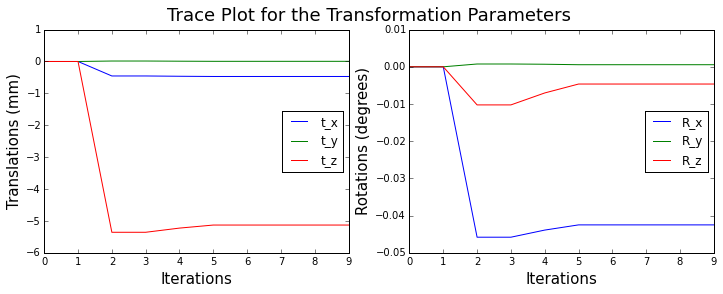

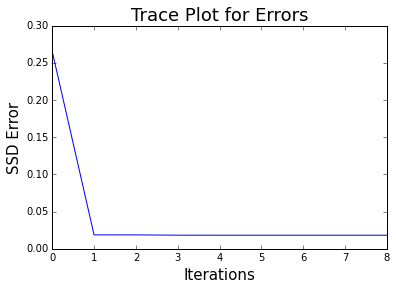

min error:  0.0182585636406
parameters at min error:  [ -7.34648289e-02   7.89069221e-04  -8.01497853e-01  -7.41704039e-04
   9.80736968e-06  -8.08588282e-05]
translation (in mm): [ -4.70174905e-01   5.05004301e-03  -5.12958626e+00]
vector of rotation: [-0.99402415  0.01314374 -0.10836617]
rotations (in degrees): 0.0427519904628


In [84]:
# GN1 with mask, non-normalized volume, Linear
from Gauss_Newton import Gauss_Newton_Linear
vol1_dervs = get_gradient_P(testVol1, mask = True)
errors, Ps = Gauss_Newton_Linear(testVol1_masked, vol1_dervs, testVol2, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 15, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

In [ ]:
# GN1 with mask, non-normalized volume
from Gauss_Newton import Gauss_Newton1
errors, Ps = Gauss_Newton(testVol1_masked, testVol2, vol2_dervs_cubic, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 15, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

In [81]:
wx, wy, wz = ax_to_w(axes_dict[rot_ax])
trans_ls = np.arange(-1,1,0.01)
cost = trans_cost_func_3d(testVol1_masked, testVol2, trans_ls, 
                          wx, wy, wz, xx, yy, zz, mask_weights, interpolation = 'trilinear')

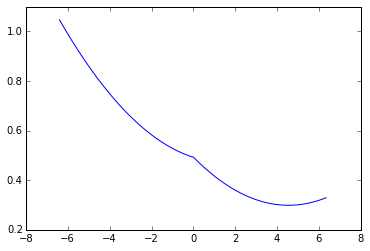

4.544


In [83]:
plt.plot(trans_ls*6.4,cost)
plt.show()
print trans_ls[np.argmin(cost)]*6.4

In [13]:
def run_trans_3d_cost(rot_ax):
    wx, wy, wz = ax_to_w(axes_dict[rot_ax])
    print rot_ax,
    cost_dict = {}
    cost_dict['trilinear'] = {}
    cost_dict['tricubic'] = {}
    cost_dict['bspline'] = {}
    for rang in [ranges[1]]:
        for i in xrange(1,6):
            ref = rep_to_angle(i, rang)
            vol_ref = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][ref],rad)
            vol_ref_masked = mask_weights * vol_ref
            for rep in xrange(1,6):
                rot_angle = rep_to_angle(i + rep*6,rang)
                true_trans = rot_angle[1]/float_res
                print true_trans,rot_angle,float_res
                trans_ls = np.arange(-1,1,0.1)
                #print 'ref',ref, 'rot angle', rot_angle
                vol_m = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][rot_angle],rad)
                vol_m_dervs_bspline = BSpline_coefficients(vol_m)
                vol_m_dervs_cubic = tricubic_derivatives(vol_m)
                cost_dict['trilinear'][rot_angle] = trans_cost_func_3d(vol_ref_masked, vol_m, trans_ls, 
                                                  wx, wy, wz, xx, yy, zz, mask_weights, interpolation = 'trilinear')
                cost_dict['tricubic'][rot_angle] = trans_cost_func_3d(vol_ref_masked, vol_m_dervs_cubic, trans_ls, 
                                                 wx, wy, wz, xx, yy, zz, mask_weights, interpolation = 'tricubic')
                cost_dict['bspline'][rot_angle] = trans_cost_func_3d(vol_ref_masked, vol_m_dervs_bspline, trans_ls, 
                                                wx, wy, wz, xx, yy, zz,  mask_weights, interpolation = 'bspline')
    return cost_dict

In [ ]:
ref = rep_to_angle(i, rang)
vol_ref = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][ref],rad)
vol_ref_masked = mask_weights * vol_ref
for rep in xrange(1,6):
    rot_angle = rep_to_angle(i + rep*6,rang)
    true_trans = rot_angle[1]/float_res
    print true_trans,rot_angle,float_res
    trans_ls = np.arange(-1,1,0.1)
    #print 'ref',ref, 'rot angle', rot_angle
    vol_m = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][rot_angle],rad)
    vol_m_dervs_bspline = BSpline_coefficients(vol_m)
    vol_m_dervs_cubic = tricubic_derivatives(vol_m)
    cost_dict['trilinear'][rot_angle] = trans_cost_func_3d(vol_ref_masked, vol_m, trans_ls, 
                                      wx, wy, wz, xx, yy, zz, mask_weights, interpolation = 'trilinear')
    cost_dict['tricubic'][rot_angle] = trans_cost_func_3d(vol_ref_masked, vol_m_dervs_cubic, trans_ls, 
                                     wx, wy, wz, xx, yy, zz, mask_weights, interpolation = 'tricubic')
    cost_dict['bspline'][rot_angle] = trans_cost_func_3d(vol_ref_masked, vol_m_dervs_bspline, trans_ls, 
                                    wx, wy, wz, xx, yy, zz,  mask_weights, interpolation = 'bspline')

In [20]:
%%time
dict_ = oct13_dict_8
res = '8'
rad = res_to_rad(res)
float_res = 8.0
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
mask_weights = get_mask_weights(xx.shape, rad)


nproc = len(keys)
pool = multiprocessing.Pool(processes = nproc)
print keys, len(keys)
cost_dict = pool.map(run_trans_3d_cost, keys)
filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_trans_3d_cost_%s.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

['xy', 'xz', 'yz', 'y', 'x', 'z'] 6
CPU times: user 3.19 s, sys: 648 ms, total: 3.84 s
Wall time: 1h 4min 56s


In [21]:
%%time
dict_ = oct13_dict_10
res = '10'
rad = res_to_rad(res)
float_res = 10.0
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
mask_weights = get_mask_weights(xx.shape, rad)

nproc = len(keys)
pool = multiprocessing.Pool(processes = nproc)
print keys, len(keys)
cost_dict = pool.map(run_trans_3d_cost, keys)
filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_trans_3d_cost_%s.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

['xy', 'xz', 'yz', 'y', 'x', 'z'] 6
CPU times: user 3.08 s, sys: 753 ms, total: 3.83 s
Wall time: 41min 35s


In [22]:
%%time
dict_ = oct13_dict_6_4
res = '6_4'
rad = res_to_rad(res)
float_res = 6.4
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
mask_weights = get_mask_weights(xx.shape, rad)


nproc = len(keys)
pool = multiprocessing.Pool(processes = nproc)
print keys, len(keys)
cost_dict = pool.map(run_trans_3d_cost, keys)
filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_trans_3d_cost_%s.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

['xy', 'xz', 'yz', 'y', 'x', 'z'] 6
CPU times: user 10.1 s, sys: 2.7 s, total: 12.8 s
Wall time: 1h 32min 51s


In [89]:
dict_ = oct13_dict_6_4
res = '6_4'
rad = res_to_rad(res)
float_res = 6.4
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
mask_weights = get_mask_weights(xx.shape, rad)
cost = run_trans_3d_cost('y')

xy 0.125 (3.0, 1) 8.0
0.25 (3.0, 2) 8.0
0.375 (3.0, 3) 8.0
0.5 (3.0, 4) 8.0
0.625 (3.0, 5) 8.0
0.125 (3.5, 1) 8.0
0.25 (3.5, 2) 8.0
0.375 (3.5, 3) 8.0
0.5 (3.5, 4) 8.0
0.625 (3.5, 5) 8.0
0.125 (4.0, 1) 8.0
0.25 (4.0, 2) 8.0
0.375 (4.0, 3) 8.0
0.5 (4.0, 4) 8.0
0.625 (4.0, 5) 8.0
0.125 (4.5, 1) 8.0
0.25 (4.5, 2) 8.0
0.375 (4.5, 3) 8.0
0.5 (4.5, 4) 8.0
0.625 (4.5, 5) 8.0
0.125 (5.0, 1) 8.0
0.25 (5.0, 2) 8.0
0.375 (5.0, 3) 8.0
0.5 (5.0, 4) 8.0
0.625 (5.0, 5) 8.0


In [42]:
float_res = 10.
for rang in ranges:
    for i in xrange(0,6):
        for rep in xrange(1,6):
            rot_angle = rep_to_angle(i + rep*6,rang)
            true_trans = rot_angle[1]/float_res
            #print rot_angle
            #print rot_angle, trans_ls[np.argmin(cost['trilinear'][rot_angle])]*8, trans_ls[np.argmin(cost['tricubic'][rot_angle])]*8, trans_ls[np.argmin(cost['bspline'][rot_angle])]*8

In [43]:
%%time

## NON-NORMALIZED VOLUMES
# Calculate the radius for masking
res = '6_4'
rad = res_to_rad(res)
rot_ax = 'y'
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
mask_weights = get_mask_weights(xx.shape, rad)

# Get two volumes to register
testVol1 = fourier_filter(oct13_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.5, 0)],rad)
testVol2 = fourier_filter(oct13_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.5, 1)],rad)
s0,s1,s2 = testVol1.shape

testVol1_masked = mask_weights*testVol1

vol2_dervs_bspline = BSpline_coefficients(testVol2)
vol2_dervs_cubic = tricubic_derivatives(testVol2)

CPU times: user 29.2 s, sys: 542 ms, total: 29.7 s
Wall time: 30.3 s


In [44]:
trans_ls = np.arange(-2.1,2.1,0.01)
print len(trans_ls)
wx, wy, wz = ax_to_w(axes_dict[rot_ax])
print wx, wy, wz

420
0 0 -1


In [45]:
%%time
cost_trilinear = trans_cost_func_3d(testVol1_masked, testVol2, trans_ls, wx, wy, wz,
                                    xx, yy, zz, mask_weights, interpolation = 'trilinear')

CPU times: user 5.65 s, sys: 424 ms, total: 6.08 s
Wall time: 6.26 s


In [46]:
%%time
cost_tricubic = trans_cost_func_3d(testVol1_masked, vol2_dervs_cubic, trans_ls, wx, wy, wz, 
                                   xx, yy, zz, mask_weights, interpolation = 'tricubic')

CPU times: user 47.9 s, sys: 1.14 s, total: 49.1 s
Wall time: 50.9 s


In [47]:
%%time
cost_bspline = trans_cost_func_3d(testVol1_masked, vol2_dervs_bspline, trans_ls, wx, wy, wz, 
                                  xx, yy, zz, mask_weights, interpolation = 'bspline')

CPU times: user 49.2 s, sys: 958 ms, total: 50.1 s
Wall time: 51.4 s


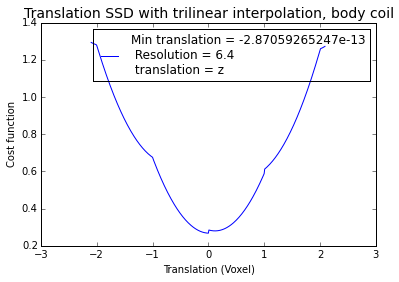

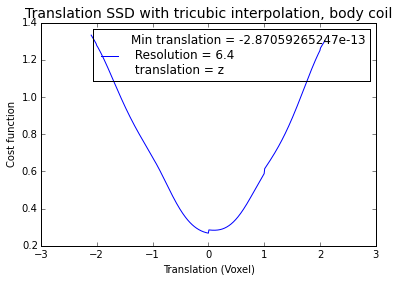

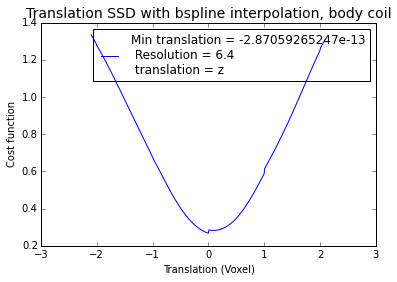

In [48]:
plot_cost_func_t(trans_ls,cost_trilinear,res,'trilinear', axes_dict[rot_ax], lw = 1)
plt.show()
plot_cost_func_t(trans_ls,cost_tricubic,res,'tricubic',axes_dict[rot_ax], lw = 1)
plt.show()
plot_cost_func_t(trans_ls,cost_bspline,res,'bspline',axes_dict[rot_ax], lw = 1)
plt.show()

In [49]:
print keys 

['xy', 'xz', 'yz', 'y', 'x', 'z']


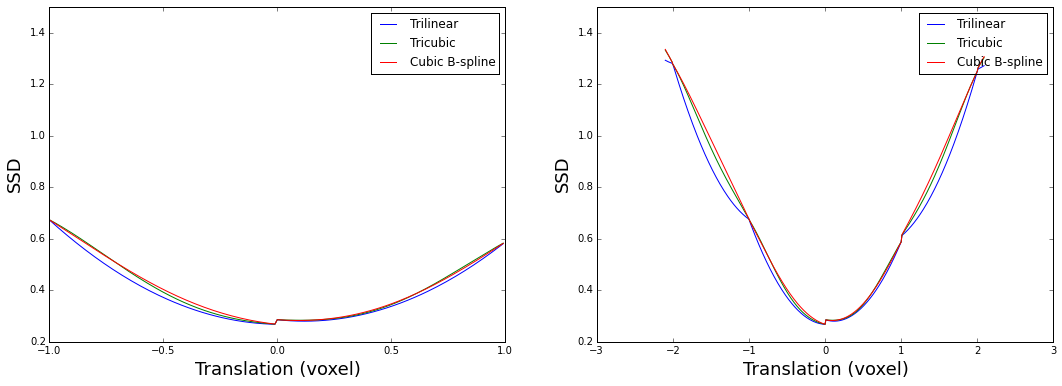

In [52]:
plt.figure(figsize = [18,6])
plt.subplot(1,2,1)
rang = '0_5_to_2_5'
ax = 'y'
idx = 3

rot_angle = (0.5, 1)
true_trans = rot_angle[1]

trans_ls = np.arange(-1,1,0.01)
plt.plot(trans_ls, trans_cost_6_4[idx]['trilinear'][rot_angle], label = 'Trilinear')
plt.plot(trans_ls, trans_cost_6_4[idx]['tricubic'][rot_angle], label = 'Tricubic')
plt.plot(trans_ls, trans_cost_6_4[idx]['bspline'][rot_angle], label = 'Cubic B-spline')
plt.xlabel('Translation (voxel)', fontsize = 18)
plt.ylabel('SSD', fontsize = 18)
plt.ylim([0.2,1.5])
plt.legend()

plt.subplot(1,2,2)
trans_ls = np.arange(-2.1,2.1,0.01)
plt.plot(trans_ls, cost_trilinear, label = 'Trilinear')
plt.plot(trans_ls, cost_tricubic, label = 'Tricubic')
plt.plot(trans_ls, cost_bspline, label = 'Cubic B-spline')
plt.xlabel('Translation (voxel)', fontsize = 18)
plt.ylabel('SSD', fontsize = 18)
plt.ylim([0.2,1.5])
plt.legend()
plt.show()

In [7]:
%%time

## NON-NORMALIZED VOLUMES
# Calculate the radius for masking
res = '6_4'
rad = res_to_rad(res)
rot_ax = 'y'
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
mask_weights = get_mask_weights(xx.shape, rad)

# Get two volumes to register
testVol1 = fourier_filter(oct13_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.5, 0)],rad)
testVol2 = fourier_filter(oct13_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.5, 2)],rad)
s0,s1,s2 = testVol1.shape

testVol1_masked = mask_weights*testVol1

vol2_dervs_bspline = BSpline_coefficients(testVol2)
vol2_dervs_cubic = tricubic_derivatives(testVol2)

CPU times: user 26.7 s, sys: 275 ms, total: 27 s
Wall time: 27.3 s


In [10]:
%%time
trans_ls = np.arange(-2.1,2.1,0.01)
print len(trans_ls)
wx, wy, wz = ax_to_w(axes_dict[rot_ax])
print wx, wy, wz

cost_trilinear2 = trans_cost_func_3d(testVol1_masked, testVol2, trans_ls, wx, wy, wz,
                                    xx, yy, zz, mask_weights, interpolation = 'trilinear')

cost_tricubic2 = trans_cost_func_3d(testVol1_masked, vol2_dervs_cubic, trans_ls, wx, wy, wz, 
                                   xx, yy, zz, mask_weights, interpolation = 'tricubic')

cost_bspline2 = trans_cost_func_3d(testVol1_masked, vol2_dervs_bspline, trans_ls, wx, wy, wz, 
                                  xx, yy, zz, mask_weights, interpolation = 'bspline')

420
0 0 -1
CPU times: user 1min 29s, sys: 2.75 s, total: 1min 31s
Wall time: 1min 32s


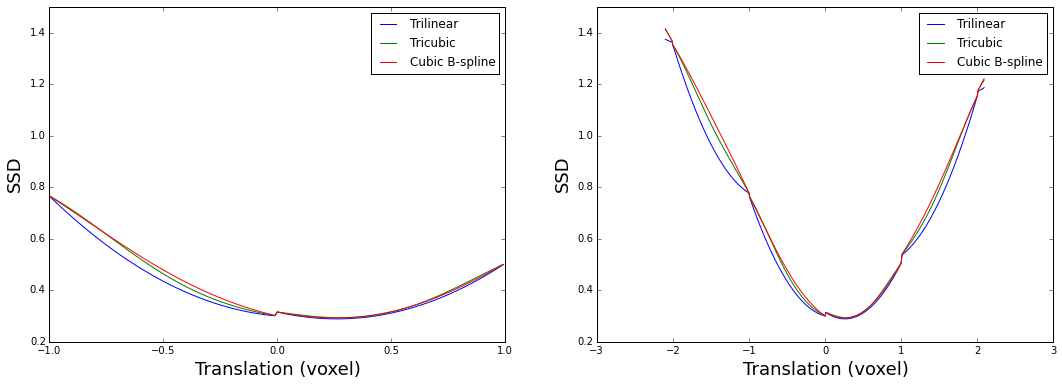

In [17]:
plt.figure(figsize = [18,6])
plt.subplot(1,2,1)
rang = '0_5_to_2_5'
ax = 'y'
idx = 3

rot_angle = (0.5, 2)
true_trans = rot_angle[1]

trans_ls = np.arange(-1,1,0.01)
plt.plot(trans_ls, trans_cost_6_4[idx]['trilinear'][rot_angle], label = 'Trilinear')
plt.plot(trans_ls, trans_cost_6_4[idx]['tricubic'][rot_angle], label = 'Tricubic')
plt.plot(trans_ls, trans_cost_6_4[idx]['bspline'][rot_angle], label = 'Cubic B-spline')
plt.xlabel('Translation (voxel)', fontsize = 18)
plt.ylabel('SSD', fontsize = 18)
plt.ylim([0.2,1.5])
plt.legend()

plt.subplot(1,2,2)
trans_ls = np.arange(-2.1,2.1,0.01)
plt.plot(trans_ls, cost_trilinear2, label = 'Trilinear')
plt.plot(trans_ls, cost_tricubic2, label = 'Tricubic')
plt.plot(trans_ls, cost_bspline2, label = 'Cubic B-spline')
plt.xlabel('Translation (voxel)', fontsize = 18)
plt.ylabel('SSD', fontsize = 18)
plt.ylim([0.2,1.5])
plt.legend()
plt.show()

## Pineapple slices

In [58]:
data_dict = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/data_dict.p','rb'))

In [59]:
def plot_volume_for_report(volume, title, colorbar = False):
    mid_slice = int(volume.shape[0]/2)
    fig, ax = plt.subplots(1,3)
    fig.set_figheight(4.5)
    fig.set_figwidth(13.5)
    if colorbar:
        for i in xrange(3):
            axx = ax[i].imshow(volume.max(axis=i), interpolation = 'None',cmap='gray')
            plt.axes(ax[i])
            fig.colorbar(axx)
    else:
        ax[2].imshow(volume[:,:,mid_slice], interpolation = 'None',cmap='gray')
        ax[1].imshow(volume[:,mid_slice,:], interpolation = 'None',cmap='gray')
        ax[0].imshow(volume[mid_slice,:,:], interpolation = 'None',cmap='gray')
    [ax[i].get_xaxis().set_ticks([]) for i in xrange(3)]
    [ax[i].get_yaxis().set_ticks([]) for i in xrange(3)]
    plt.tight_layout(pad=0, w_pad=0.3, h_pad=0.3)
    plt.suptitle(title, fontsize=20)
    [ax[i].grid('off') for i in xrange(3)]
    plt.show()
    plt.close(fig)

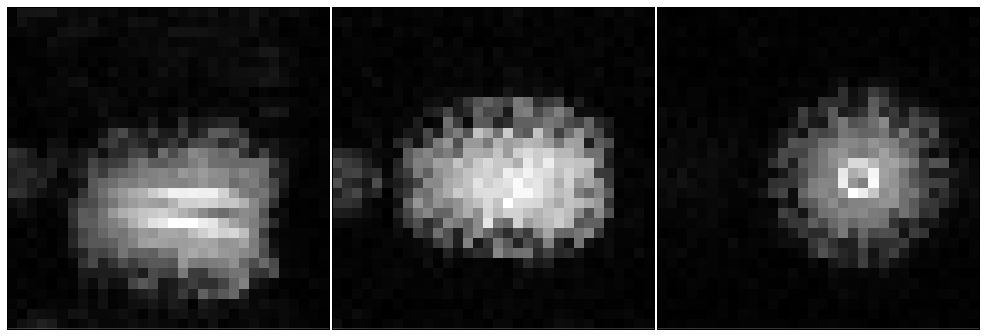

In [173]:
vol = data_dict['8mm']['body']['iso'][0]
plot_volume_for_report(vol, "")

## Example image to demonstrate rotation aliasing

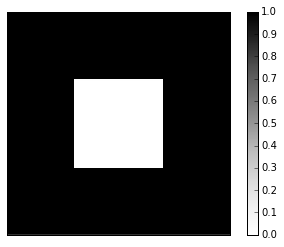

In [96]:
X  = np.zeros([100,100])
X[:30,:] = 1
X[-30:,:] = 1
X[:,:30] = 1
X[:,-30:] = 1
plt.imshow(X, interpolation = 'None',cmap=plt.cm.Greys)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

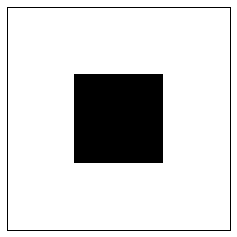

In [97]:
from scipy import misc, ndimage
X  = np.zeros([100,100])
X[:30,:] = 1
X[-30:,:] = 1
X[:,:30] = 1
X[:,-30:] = 1

X_rot = ndimage.rotate(X, 45, reshape=False)
fig = plt.figure()
plt.imshow(X, cmap=plt.cm.gray, interpolation='None')
plt.xticks([])
plt.yticks([])
plt.show()
# plt.imshow(X_rot, cmap=plt.cm.gray, interpolation='None')
# #plt.axis('off')
# plt.show()

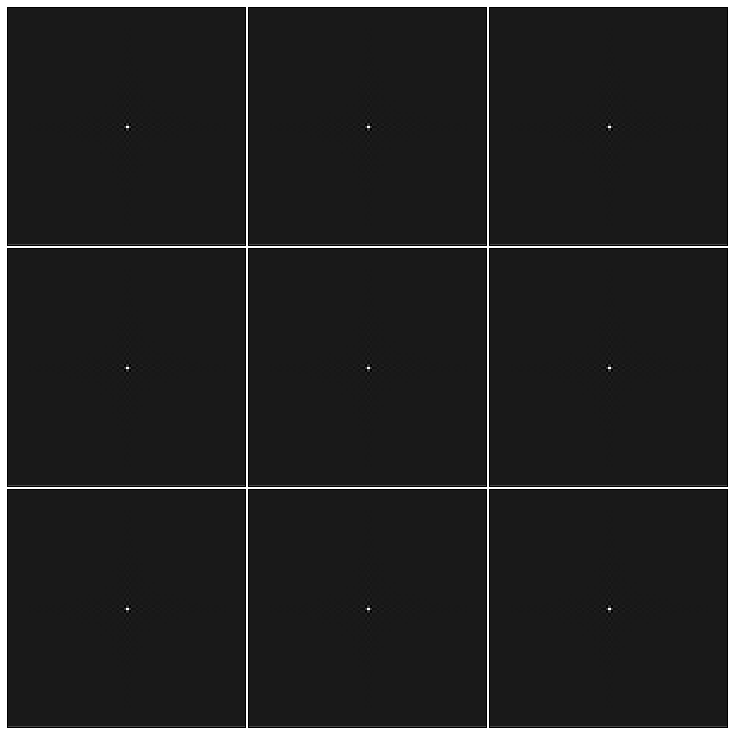

In [95]:
X_f = np.fft.fftshift(np.fft.fft2(X))
plt.figure(figsize = [10,10])
for i in xrange(1,10):
    plt.subplot(3,3,i)
    plt.imshow(X_f.real, interpolation = 'None',cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, w_pad=0.3, h_pad=0.3)

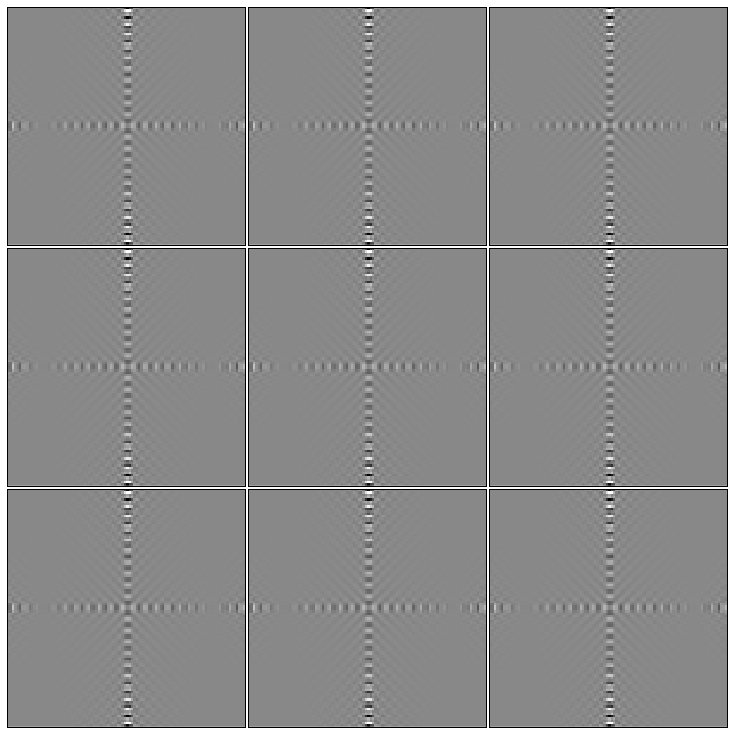

In [206]:
X_f_rot = ndimage.rotate(X_f.real, 45, reshape=False)
plt.figure(figsize = [10,10])
for i in xrange(1,10):
    plt.subplot(3,3,i)
    plt.imshow(X_f_rot.real, interpolation = 'None',cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, w_pad=0.3, h_pad=0.3)

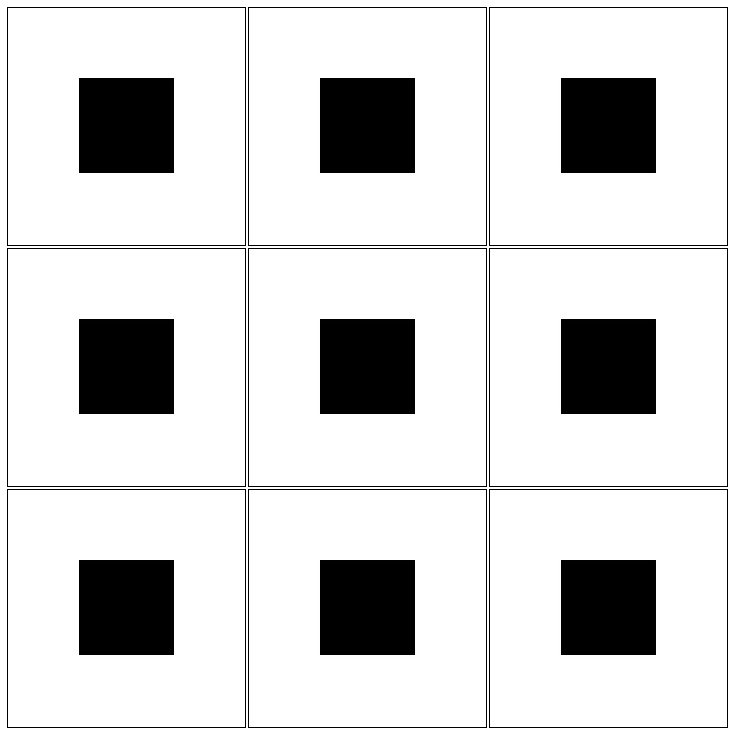

In [199]:
plt.figure(figsize = [10,10])
for i in xrange(1,10):
    plt.subplot(3,3,i)
    plt.imshow(X, interpolation = 'None',cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, w_pad=0.3, h_pad=0.3)

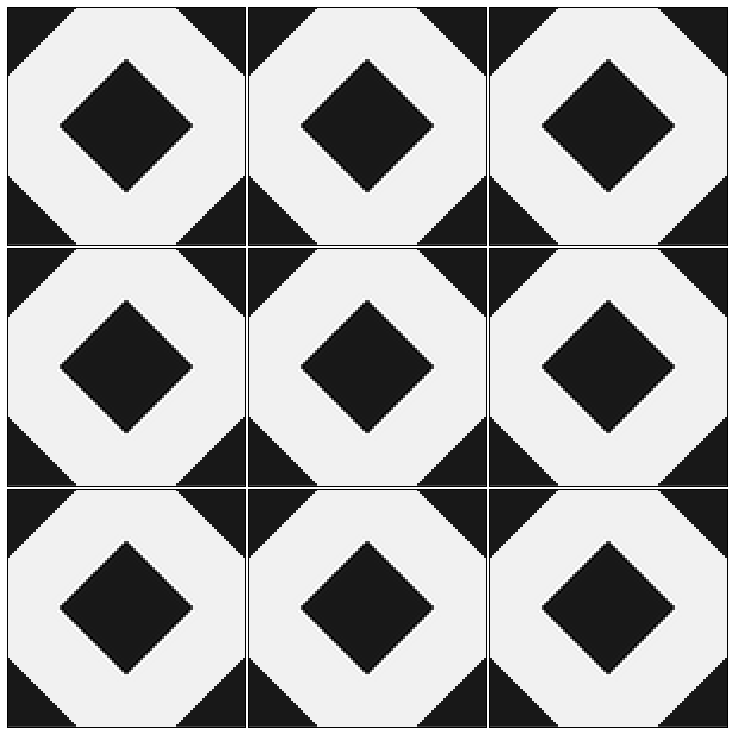

In [196]:
plt.figure(figsize = [10,10])
for i in xrange(1,10):
    plt.subplot(3,3,i)
    plt.imshow(X_rot, interpolation = 'None',cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, w_pad=0.3, h_pad=0.3)

### Analytical plots

In [5]:
def f(x):
    if abs(x) <= 1./2:
        return 1.0
    else:
        return 0.0
unitBox = np.vectorize(f)

In [6]:
def g(kx, ky):
    if kx == 0:
        cx = 1
    else:
        cx = np.sin(51*np.pi*kx/100.)/(51*np.sin(np.pi*kx/100.))

    if ky == 0:
        cy = 1
    else:
        cy = np.sin(51*np.pi*ky/100.)/(51*np.sin(np.pi*ky/100.))
    
    return 1./100.* cx * cy

freqBox = np.vectorize(g)

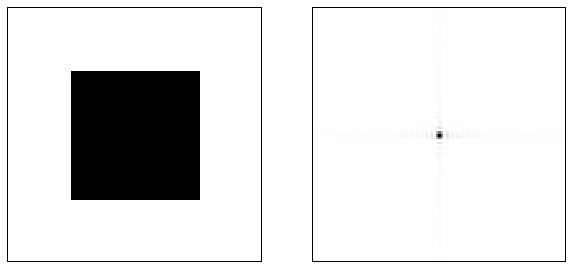

In [7]:
x = np.arange(-50, 50, 1)
y = np.arange(-50, 50, 1)
xx, yy = np.meshgrid(x, y)


im = unitBox(2.*xx/100)*unitBox(2.*yy/100)/(51**2)
plt.figure(figsize = [10,6])
plt.subplot(1,2,1)
plt.imshow(im, interpolation = 'None',cmap='Greys')
plt.xticks([])
plt.yticks([])

im_f_anly = freqBox(xx,yy)
plt.subplot(1,2,2)
plt.imshow(abs(im_f_anly), interpolation = 'None',cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.show()

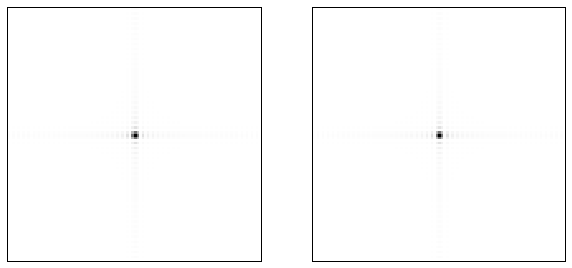

In [11]:
kx = np.arange(-50, 50, 1)
ky = np.arange(-50, 50, 1)
xx, yy = np.meshgrid(kx, ky)

im_f_anly = freqBox(xx,yy)
plt.figure(figsize = [10,6])
plt.subplot(1,2,1)
plt.imshow(abs(im_f_anly), interpolation = 'None',cmap='Greys')
plt.xticks([])
plt.yticks([])

im_f = np.fft.fftshift(np.fft.fft2(im))
plt.subplot(1,2,2)
plt.imshow(abs(im_f), interpolation = 'None',cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.show()

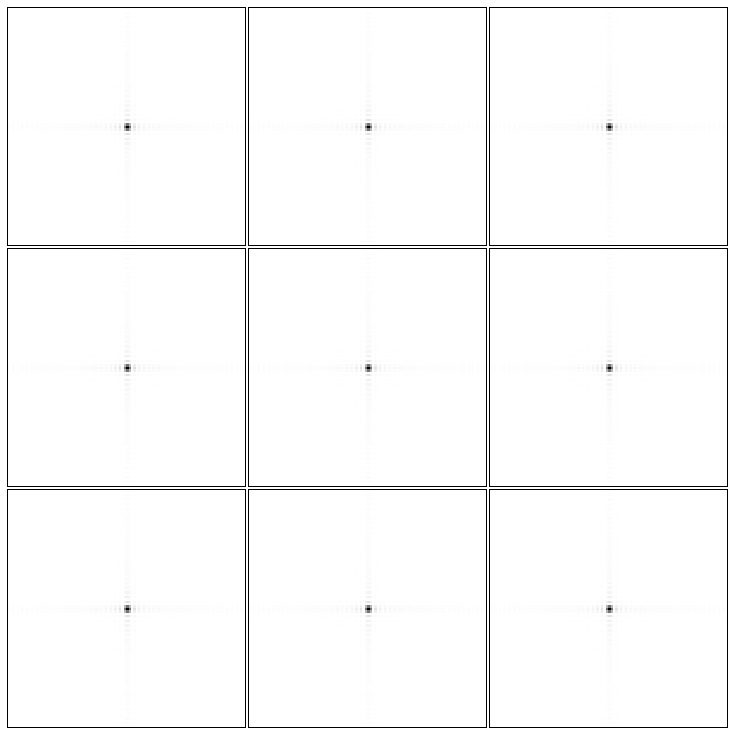

In [12]:
plt.figure(figsize = [10,10])
for i in xrange(1,10):
    plt.subplot(3,3,i)
    plt.imshow(abs(im_f_anly), interpolation = 'None',cmap=plt.cm.Greys)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, w_pad=0.3, h_pad=0.3)

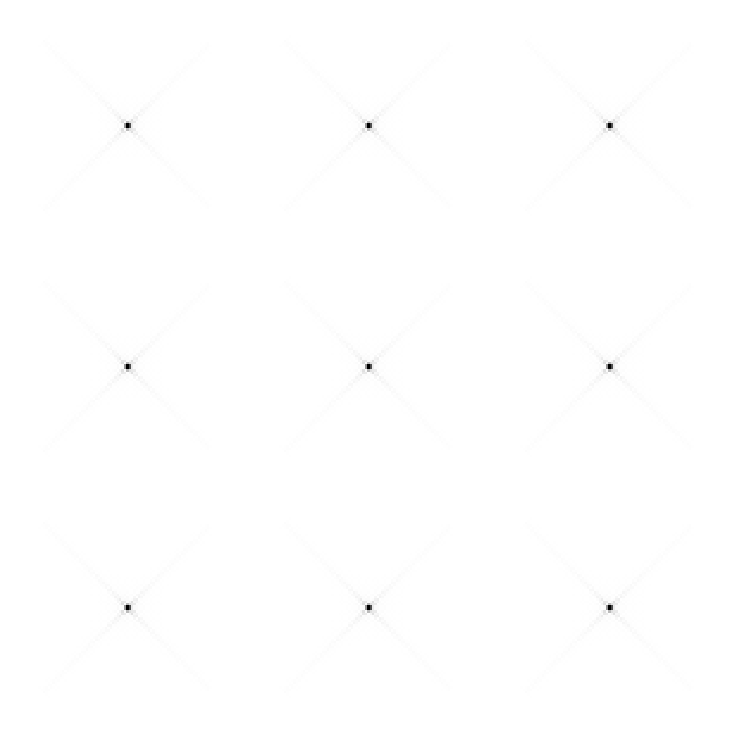

In [9]:
from scipy import ndimage
fourier_rot = ndimage.rotate(im_f_anly, 45, reshape=False)
plt.figure(figsize = [10,10])
for i in xrange(1,10):
    plt.subplot(3,3,i)
    plt.imshow(abs(fourier_rot), interpolation = 'None',cmap=plt.cm.Greys)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
plt.tight_layout(pad=0, w_pad=0.3, h_pad=0.3)

In [41]:
np.min(rotated[np.where(rotated != 1)])

-0.043636174623252949

In [58]:
rotated[rotated-0.3844675 <1e-5]= -1

In [70]:
mask = np.zeros(rotated.shape)
mask_1 = rotated == -1
mask1 = rotated == 1
for i in xrange(100):
    for j in xrange(100):
        mask[i,j] = not mask_1[i,j] and not mask1[i, j]
mask = mask.astype(bool)

In [50]:
rotated[41,41]-0.3844675

1.7904412064062569e-08

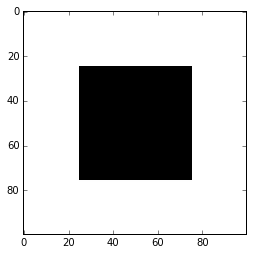

In [28]:
plt.imshow(im*1000, interpolation = 'None',cmap=plt.cm.Greys)

In [34]:
rotated

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

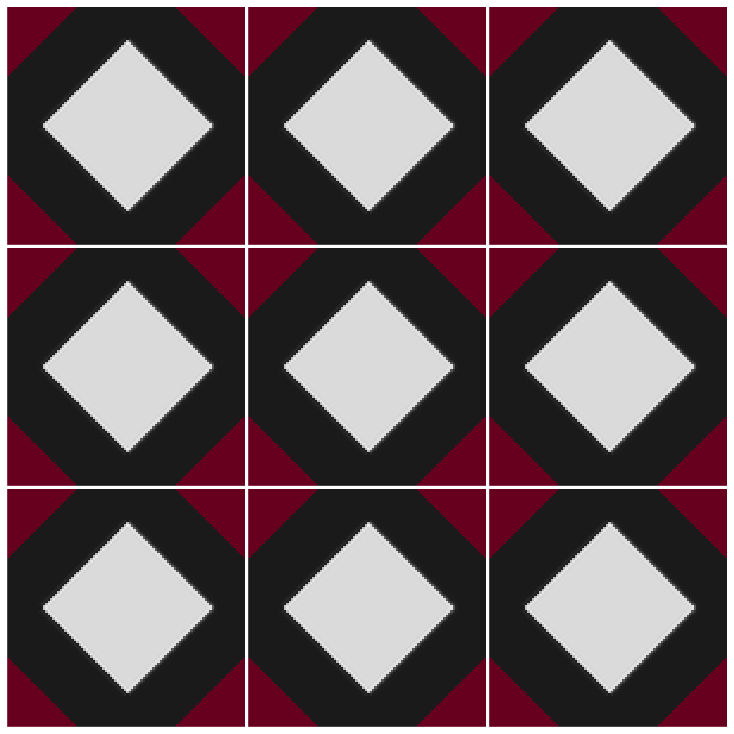

In [38]:
from scipy import ndimage
rotated = ndimage.rotate(im*1000, 45, reshape=False,cval=1)
plt.figure(figsize = [10,10])
for i in xrange(1,10):
    plt.subplot(3,3,i)
    plt.imshow(-abs(rotated), interpolation = 'None',cmap='RdGy')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
plt.tight_layout(pad=0, w_pad=0.3, h_pad=0.3)

In [76]:
def rot_Matrix(theta):
    theta = theta*np.pi/180.
    return np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

In [88]:
im_rot = np.empty(im.shape)
im_f_rot = np.empty(im.shape)
for i in xrange(100):
    for j in xrange(100):
        new_x, new_y = R.dot(np.array([xx[i, j], yy[i,j]]))
        im_rot[i, j] = unitBox(2.*new_x/100)*unitBox(2.*new_y/100)/(51**2)
        im_f_rot[i, j] = freqBox(new_x, new_y)

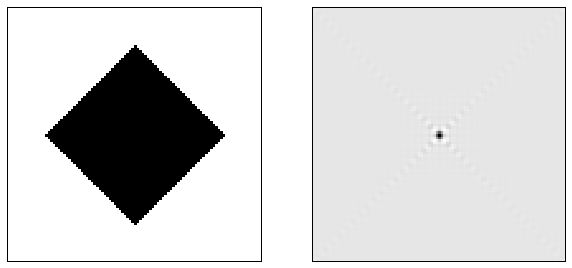

In [89]:
plt.figure(figsize = [10,6])
plt.subplot(1,2,1)
plt.imshow(im_rot, interpolation = 'None',cmap='Greys')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(im_f_rot, interpolation = 'None',cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.show()

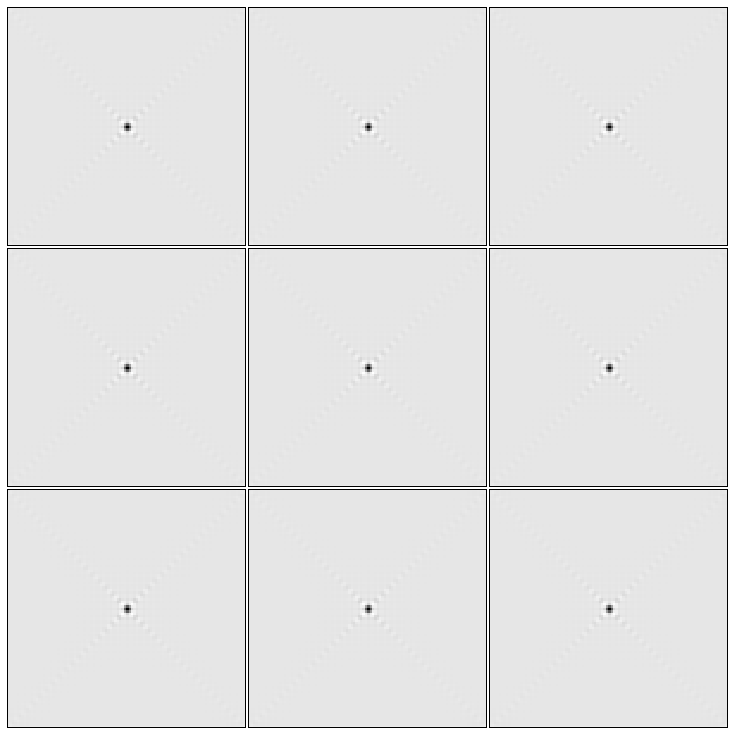

In [98]:
plt.figure(figsize = [10,10])
for i in xrange(1,10):
    plt.subplot(3,3,i)
    plt.imshow(im_f_rot.real, interpolation = 'None',cmap=plt.cm.Greys)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, w_pad=0.3, h_pad=0.3)

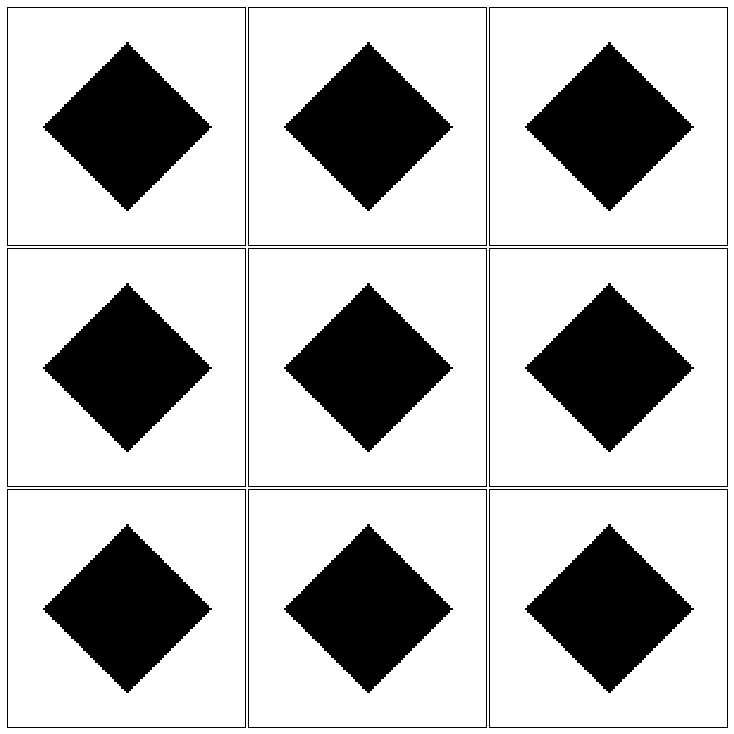

In [100]:
plt.figure(figsize = [10,10])
for i in xrange(1,10):
    plt.subplot(3,3,i)
    plt.imshow(im_rot, interpolation = 'None',cmap=plt.cm.Greys)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, w_pad=0.3, h_pad=0.3)